In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from glob import glob
import pickle
from collections import OrderedDict
from scipy import optimize

import matplotlib as mpl
mpl.rcParams["savefig.dpi"] = 600
#mpl.rcParams["font.size"] = 20
mpl.rcParams["lines.linewidth"] = 2
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

Results files should be made previously using:
`./alt_aggregate_results.py` and by setting the correct `date` and `regions`

In [2]:
test = True

pdf = True
svg = True

xlab = 'Number of years of input data'

norm = {
    'CONUS' : 303461, # Mean demand (MW) for file CONUS_demand_synthetic_1950-2020_MEM.csv
}
denom = norm['CONUS']

title_map = {
    'SWB' : 'Solar + wind + battery',
    'SWBNG' : 'Solar + wind +\nbattery + natural gas',
    'SWBPGP' : 'Solar + wind +\n'+r'battery + H$_{2}$'
}

year_range = range(1979, 2021)
default_years = [1, 2, 3, 4, 5, 7, 10, 15, 25, 40] 

In [3]:
dfs_costs = OrderedDict()
dfs_LL = OrderedDict()
for techs in title_map.keys():
    
    df = pd.read_csv(f'n_years_ALL_CONUS_{techs}.csv')
    dfs_costs[techs] = df[ df['n_years'] <= 40 ]
    dfs_LL[techs] = pd.read_csv(f'n_years_ALL_CONUS_{techs}_TestArchs_10YrTests.csv')
    print(len(dfs_costs[techs].index))
    print(len(dfs_LL[techs].index))
    #print(dfs_LL[techs]['lost_load dispatch'])

3820
3820
3820
3820
3820
3820


# Figure 2?


LL
SWB
R2 = 0.9988
R2 = 0.3218
a = 0.00102 +/- 1.856%
b = -1.05371 +/- 2.891%
SWBNG
R2 = 0.9979
R2 = 0.2083
a = 0.00013 +/- 2.404%
b = -0.98263 +/- 3.720%
SWBPGP
R2 = 0.9838
R2 = 0.1617
a = 0.01070 +/- 2.258%
b = -0.57216 +/- 3.914%

Costs
SWB
R2 = 0.9951
R2 = 0.3554
a = 0.19127 +/- 0.298%
b = 0.07759 +/- 2.181%
SWBNG
R2 = 0.9610
R2 = 0.0406
a = 0.09752 +/- 0.094%
b = 0.00712 +/- 7.859%
SWBPGP
R2 = 0.9929
R2 = 0.3466
a = 0.13200 +/- 0.138%
b = 0.03632 +/- 2.218%


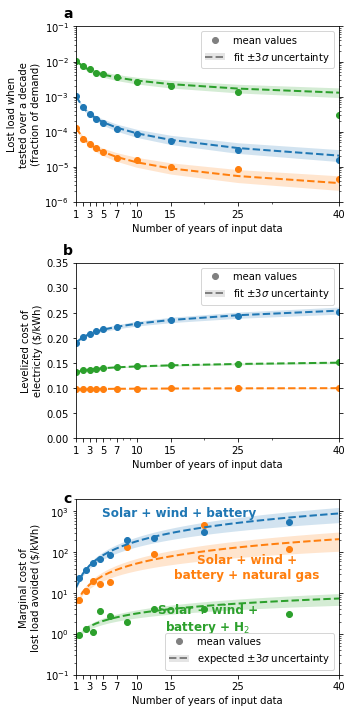

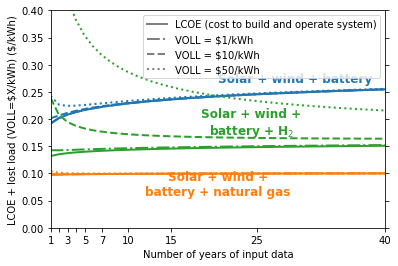

In [10]:
# Method from http://astronotes.co.uk/blog/2018/05/31/understanding-errors-from-atlas-phase-curve-fitting.html
def get_fit_uncert(popt, perr, nyrs, sigma):
    
    p1 = power_fit(nyrs, popt[0] + sigma * perr[0], popt[1] + sigma * perr[1])
    p2 = power_fit(nyrs, popt[0] - sigma * perr[0], popt[1] + sigma * perr[1])
    p3 = power_fit(nyrs, popt[0] + sigma * perr[0], popt[1] - sigma * perr[1])
    p4 = power_fit(nyrs, popt[0] - sigma * perr[0], popt[1] - sigma * perr[1])
    #axs[i].plot(nyrs, p1, 'k-')
    maxs = np.maximum( np.maximum(p1, p2), np.maximum(p3, p4) )
    mins = np.minimum( np.minimum(p1, p2), np.minimum(p3, p4) )
    return mins, maxs

labs = {
    'syst_cost' : 'Levelized cost of\nelectricity ($/kWh)',
    'lost_load' : 'Lost load when\ntested over a decade\n(fraction of demand)'
}

def fit_and_plot_var(i, axs, dfs, var, ylim, show_obs=False):
    
    this_denom = denom
    #if var == 'syst_cost' else 1
    #this_denom = 1
    
    fits = OrderedDict()
    for j, techs in enumerate(title_map.keys()):
        df = dfs[techs]
        # Calc mean and std by nyrs
        means, stds, nyrs = [], [], []
        for NYRS in df['n_years'].unique():
            df1 = df[ df['n_years'] == NYRS ]
            ll = df1[var]/this_denom
            means.append( np.mean( ll ) )
            stds.append( np.std( ll ) )
            nyrs.append( NYRS )
        means = np.array(means)
        stds = np.array(stds)
        nyrs = np.array(nyrs)
        
        if show_obs:
            axs[i].scatter(df['n_years'], df[var]/this_denom, marker='o', c=f'C{j}', alpha=0.1)
        axs[i].scatter(nyrs, means, marker='o', c=f'C{j}', label=f'{techs} mean')
        #axs[i].plot(nyrs, means + stds, c=f'C{j}', linestyle=':', label=r'+/- 1 $\sigma$')
        #axs[i].plot(nyrs, means - stds, c=f'C{j}', linestyle=':', label='__no_label__')
        
        popt, pcov = optimize.curve_fit(power_fit, df['n_years'], df[var]/this_denom)
        perr = np.sqrt(np.diag(pcov))
        #print(popt)
        #print(pcov)
        sigma = 3
        mins, maxs = get_fit_uncert(popt, perr, nyrs, sigma)
        axs[i].fill_between(nyrs, mins, maxs, alpha=0.2, color=f'C{j}', label='_no_label_', linewidth=0)
        fits[techs] = [popt, perr, mins, maxs]
        axs[i].plot(nyrs, power_fit(nyrs, *popt), c=f'C{j}', linestyle='--', label='_no_label_')
        
        
        print(techs)
        r_squared_and_text(techs, axs[i], nyrs, means, power_fit, popt, 'power')
        r_squared_and_text(techs, axs[i], df['n_years'], df[var]/this_denom, power_fit, popt, 'power')
        for k, letter in enumerate(['a', 'b']):
            print(f"{letter} = {popt[k]:.5f} +/- {abs(perr[k]/popt[k])*100:.3f}%")
    #axs[i].set_title(var)
    axs[i].set_ylim(ylim)
    axs[i].set_ylabel(labs[var])
    if not 'Levelized' in labs[var]:
        axs[i].set_yscale('log')
    axs[i].xaxis.set_major_locator(mpl.ticker.FixedLocator([.1, .2, .3]))
    axs[i].xaxis.set_minor_locator(mpl.ticker.LogLocator(numticks=20, subs="auto"))
    #axs[i].set_xscale('log')
    #axs[i].legend(bbox_to_anchor=(1.05, 0.9))
    #if i > 1:
    custom_legend(axs, i)
    xticks(axs, i)
    return fits

def add_margina_LL_reduction(i, axs, ll_fits, cost_fits, ylim):
    nyrs = np.linspace(1, 40, 41)
    for j, techs in enumerate(title_map.keys()):
        
        p0_ll = power_fit(nyrs, *(ll_fits[techs][0]))
        epsilon = 1e-3
        p1_ll = power_fit(nyrs + epsilon, *(ll_fits[techs][0]))
        d_ll = -1 * (p1_ll - p0_ll)/epsilon
        #print(f"p0_ll: {p0_ll}")
        #print(f"p1_ll: {p1_ll}")
        #print(f"d_ll: {d_ll}")
        #print("d_ll", d_ll)
        p0_cost = power_fit(nyrs, *(cost_fits[techs][0]))
        epsilon = 1e-3
        p1_cost = power_fit(nyrs + epsilon, *(cost_fits[techs][0]))
        d_cost = (p1_cost - p0_cost)/epsilon
        #print("d_cost", d_cost)
        #print("div", d_cost/d_ll)
        
        div = d_cost/d_ll
        #axs[i].plot(nyrs, div, c=f'C{j}', linestyle='--', label=f'{techs}')
        
        # Uncertainty
        sigma = 3
        mins_ll, maxs_ll = get_fit_uncert(ll_fits[techs][0], ll_fits[techs][1], nyrs, sigma)
        mins_cost, maxs_cost = get_fit_uncert(cost_fits[techs][0], cost_fits[techs][1], nyrs, sigma)
        # Use standard error propagation for division
        # dZ/z = sqrt( (dX/x)**2 + (dy/y)**2 )
        dZ = []
        for k in range(len(nyrs)):
            to_square = ((maxs_ll[k] - mins_ll[k])/(2 * p0_ll[k]))**2
            to_square += ((maxs_cost[k] - mins_cost[k])/(2 * p0_cost[k]))**2
            dZ.append( np.sqrt( to_square ) *  div[k] )
            
        axs[i].fill_between(nyrs, div - dZ, div + dZ, color=f'C{j}', alpha=0.2, label='_no_label_', linewidth=0) # label=str(sigma)+r'$\sigma$'
        #print(div)
    
    axs[i].set_ylabel('Marginal cost of\nlost load avoided ($/kWh)')
    axs[i].set_ylim(ylim)
    axs[i].set_yscale('log')
    add_label_text(axs[i])
    #axs[i].set_xscale('log')
    #axs[i].legend(bbox_to_anchor=(1.05, 0.9))
    return

    

def calc_marginal_curve(i, axs, ll_fits, cost_fits):
    nyrs = np.linspace(1, 40, 41)
    for j, techs in enumerate(title_map.keys()):
        
        a, b = cost_fits[techs][0]
        c, d = ll_fits[techs][0]
        #print(a, b, c, d)
        A = (a * b)/(c * d)
        B = (b - d)
        pMarg = power_fit(nyrs, A, B)
        #print(pMarg)
        axs[i].plot(nyrs, -1 * pMarg, c=f'C{j}', linestyle='--', label=f'{techs}')
        

def add_observed_marginal_reductions(i, axs):
    nyrs = [1.5, 2.5, 3.5, 4.5, 6, 8.5, 12.5, 20, 32.5]
    swb = np.array([22.90787655, 36.32129943, 53.91101743, 70.40478126, 87.80181648, 200.7952961, 224.3254617, 309.7565728, 551.9730426])
    swbng = np.array([6.719003074, 11.50288768, 20.09598415, 16.41103941, 18.86578161, 135.5394177, 90.02424986, 457.8994946, 118.6542255])
    swbpgp = np.array([0.93316275, 1.342600306, 1.115877863, 3.619469585, 2.720338409, 2.006416226, 4.116212573, 4.00947125, 3.013385284])
    axs[i].scatter(nyrs, swb, color='C0', label='_no_label_')
    axs[i].scatter(nyrs, swbng, color='C1', label='_no_label_')
    axs[i].scatter(nyrs, swbpgp, color='C2', label='_no_label_')
    #axs[i].legend(bbox_to_anchor=(1.05, 0.9))
    custom_legend(axs, i)
    xticks(axs, i)

def plot_all_fits(dfs_costs, dfs_LL, show_obs=False):
    
    fits = {}
    #fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6.5), sharex=True)
    #AXS = [axs[0][0], axs[0][1], axs[1][0], axs[1][1]]
    
    #gs_kw = dict(width_ratios=[1, 1], height_ratios=[1, 2])
    #fig = plt.figure(figsize=(8, 6.5), layout="constrained", gridspec_kw=gs_kw)
    #spec = fig.add_gridspec(2, 2)
    #ax00 = fig.add_subplot(spec[0, 0])
    #ax01 = fig.add_subplot(spec[0, 1])
    #ax1 = fig.add_subplot(spec[1, :])
    
    

    fig, AXS = plt.subplots(nrows=3, figsize=(5, 10))
    
    # Do LL fit
    print("\nLL")
    #size = (5,4)
    #fig, ax = plt.subplots(figsize=size)
    ll_fits = fit_and_plot_var(0, AXS, dfs_LL, 'lost_load', [1e-6, .1], show_obs)
    #finish(ax, 0, show_obs)
    
    # Do costs fit and plot
    print("\nCosts")
    #fig, ax = plt.subplots(figsize=size)
    cost_fits = fit_and_plot_var(1, AXS, dfs_costs, 'syst_cost', [.0, 0.35], show_obs)
    #finish(ax, 1, show_obs)
    
    # Divide and propagate errors
    #fig, ax = plt.subplots(figsize=size)
    add_margina_LL_reduction(2, AXS, ll_fits, cost_fits, [.1, 2000])
    add_observed_marginal_reductions(2, AXS)
    calc_marginal_curve(2, AXS, ll_fits, cost_fits)
    #plt.axhline(y=10, color='k', linestyle':')
    #plt.axhline(y = 10, color = 'k', linestyle = ':')
    #finish(ax, 2, show_obs)
    
    #plt.subplots_adjust(left=.11, right=.99, wspace=.3, bottom=.13, top=.88)
    plt.tight_layout()
    
    
    if pdf:
        plt.savefig(f"plots/fig2.pdf")
    if svg:
        plt.savefig(f"plots/fig2.svg")
    plt.savefig(f"plots/fig2.png")
    
    # TOTAL Costs
    fig, ax = plt.subplots()
    add_total_costs(ax, ll_fits, cost_fits)
    
    return

def add_total_costs(ax, ll_fits, cost_fits):
    nyrs = np.linspace(1, 40, 41)
    colors = ['C0', 'C1', 'C2']
    volls = [1, 10, 50]
    for j, techs in enumerate(title_map.keys()):
        
        
        
        p0_ll = power_fit(nyrs, *(ll_fits[techs][0]))
        p0_cost = power_fit(nyrs, *(cost_fits[techs][0]))
        
        styles = ['-.', '--', ':']
        ax.plot(nyrs, p0_cost, color=colors[j], lw=2, label="LCOE baseline (panel a)")
        for k, voll in enumerate(volls):
            ax.plot(nyrs, p0_cost + p0_ll * voll, color=colors[j], ls=styles[k], label=f"LCOE + ${voll}/kWh VOLL")
        
    
    ax.set_ylabel('LCOE + lost load (VOLL=\$X/kWh) (\$/kWh)')
    
    #ax.set_yscale('log')
    #add_label_text(axs[i])
    ax.set_ylim(0, 0.4)
    #ax.set_xscale('log')
    xticks([ax,], 0, skip_panels=True)
    
    #from matplotlib.lines import Line2D
    legend_elements = [
        mpl.lines.Line2D([0], [0], color='gray', linestyle='-'),
        mpl.lines.Line2D([0], [0], color='gray', linestyle='-.'),
        mpl.lines.Line2D([0], [0], color='gray', linestyle='--'),
        mpl.lines.Line2D([0], [0], color='gray', linestyle=':')
    ]
    loc = 'upper right'
    labs = ['LCOE (cost to build and operate system)',]
    for voll in volls:
        labs.append(f'VOLL = ${voll}/kWh')
    ax.legend(legend_elements, labs, loc=loc)#bbox_to_anchor=(1.05, 0.9))

    ax.text(0.5, 0.67, title_map['SWB'], fontsize=12, 
                weight='bold', color='C0', transform=ax.transAxes)
    ax.text(0.5, 0.15, title_map['SWBNG'], fontsize=12, horizontalalignment='center',
                weight='bold', color='C1', transform=ax.transAxes)
    ax.text(0.6, 0.43, title_map['SWBPGP'], fontsize=12, horizontalalignment='center',
                weight='bold', color='C2', transform=ax.transAxes)
    
    if pdf:
        plt.savefig(f"plots/fig2si.pdf")
    if svg:
        plt.savefig(f"plots/fig2si.svg")
    plt.savefig(f"plots/fig2si.png")
    
    return

def finish(ax, cnt, show_obs):
    plt.tight_layout()
    app = '' if not show_obs else '_show_points'
    s_name = f"plots/marginal_fits2_panels{app}_cnt{cnt}.png"
    plt.savefig(s_name)
    print(s_name)
    #plt.close()
    return


def custom_legend(axs, i):
    #from matplotlib.lines import Line2D
    legend_elements = [
        mpl.lines.Line2D([0], [0], color='gray', markerfacecolor='gray', linewidth=0, marker='o'),
        (mpl.lines.Line2D([0], [0], color='gray', linestyle='--'),
        mpl.patches.Patch(facecolor='gray', linewidth=0, alpha=0.2))
    ]
    loc = 'lower right' if axs[i].get_ylim()[0] > 1e-4 else 'upper right'
    fit = 'fit' if i < 2 else 'expected'
    axs[i].legend(legend_elements, ['mean values', fit+r' $\pm$3$\sigma$ uncertainty'], loc=loc)#bbox_to_anchor=(1.05, 0.9))
    return


def xticks(axs, i, skip_panels=False):
    yrs_labs = []
    for y in default_years:
        skip_lab = [] if np.max(default_years) == 5 else [2, 4]
        yrs_labs.append(str(y)) if y not in skip_lab else yrs_labs.append('')
    axs[i].set_xticks(default_years)
    axs[i].set_xticklabels(yrs_labs)
    axs[i].set_xlim(1, 40)
    #if i > 1:
    axs[i].set_xlabel(xlab)
    if not skip_panels:
        label_dict = {
            0 : "a",
            1 : "b",
            2 : "c",
            3 : "d"
        }
        minus = 0 if i < 2 else 0.07
        axs[i].text(-0.05, 1.05 - minus, label_dict[i], fontsize=14, weight='bold', transform=axs[i].transAxes)
    #if i == 1:
    #    #print(axs[i].get_yticks())
    #    axs[i].yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    axs[i].tick_params(which='both', right=True)
    return
   

def exp_fit(x, a, b):
    return a * np.exp(b * x)

def power_fit(x, a, b):
    return a * np.power((x), b)

def linear_fit(x, a, b):
    return a + x * b

def r_squared_and_text(techs, ax, xdata, ydata, f, popt, fit_type):
    residuals = ydata - f(xdata, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    print(f"R2 = {r_squared:.4f}")
    return
    if fit_type == 'power law':
        y = .25
        if logY and techs == 'SWB':
            y = .65
        if logY and techs == 'SWBNG':
            y = .415
        if not logY and techs == 'SWBPGP':
            y = .65
        ax.text(.2, y, f"y = {popt[0]:.3} * x^({popt[1]:.3f})\n"+r"R$^{2}$"+f" = {r_squared:.3f}", transform=ax.transAxes)
    elif fit_type == 'linear':
        y = .65
        if techs == 'SWBNG':
            y = .415
        if techs == 'SWBPGP':
            y = .05
        ax.text(.2, y, f"y = {popt[0]:.3} + x * ({popt[1]:.3f})\n"+r"R$^{2}$"+f" = {r_squared:.3f}", transform=ax.transAxes)

def add_label_text(ax):
    ax.text(0.1, 0.9, title_map['SWB'], fontsize=12, 
                weight='bold', color='C0', transform=ax.transAxes)
    ax.text(0.65, 0.55, title_map['SWBNG'], fontsize=12, horizontalalignment='center',
                weight='bold', color='C1', transform=ax.transAxes)
    ax.text(0.5, 0.25, title_map['SWBPGP'], fontsize=12, horizontalalignment='center',
                weight='bold', color='C2', transform=ax.transAxes)

        
fits = {}
plot_all_fits(dfs_costs, dfs_LL)
#plot_all_fits(dfs_costs, dfs_LL, show_obs=True)